# $k$-匿名性

$k$-匿名性（$k$-Anonymity）{cite}`sweeney2002`是一个*用数学语言描述的隐私定义*。$k$-匿名性的定义用数学描述了我们的直观想法：一部分辅助信息不应该"过多地"缩小个体所属记录的可能范围。换句话说，$k$-匿名性的目的是为了保证每个个体都能"融入人群"。

```{admonition} 学习目标
阅读本章后，你将会理解：
- $k$-匿名性的定义
- 如何验证数据集是否满足$k$-匿名性
- 如何泛化数据集，使数据集满足$k$-匿名性
- $k$-匿名性的局限性。
```

把数据集按照数据集各个列中的特定子集分组，即按照*准标识*（Quasi-Identifier）分组，使每个分组中的个体都拥有相同的准标识。如果数据集中的每个个体所属分组的大小都至少为$k$，则我们称此数据集满足$k$-匿名性。此时，每个个体都"融入"其所在的分组中了。这样一来，虽然攻击者仍然可以将攻击范围缩小至特定的分组中，但攻击者无法进一步确定分组中的哪个个体才是攻击目标。

```{admonition} 定义
用数学语言描述此概念，对于特定的$k$，如果：

- 对于任意记录$r_1 \in D$，存在至少$k - 1$条其他的记录$r_2 \dots r_k \in D$，使得$\Pi_{qi(D)} r_1 = \Pi_{qi(D)} r_2, \dots, \Pi_{qi(D)} r_1 = \Pi_{qi(D)} r_k$

其中$qi(D)$是$D$的准标识，$\Pi_{qi(D)} r$表示包含准标识的列$r$（即准标识的投影），则称数据集$D$满足$k$-匿名性。
```

## 验证$k$-匿名性

我们先从一个小数据集开始。我们可以直接查看小数据集所包含的数据，从而直观判断出此数据集是否满足$k$-匿名性。这个数据集包含年龄列和两个考试分数列。很明显，对于任意$k > 1$，此数据集都不满足$k$-匿名性。任何数据集都天然满足$k = 1$的$k$-匿名性，因为任意记录自身都可以构成一个大小为$1$的分组。

In [82]:
import pandas as pd
import numpy as np
from mplfonts.bin.cli import init
init()
from mplfonts import use_font
use_font('SimHei')
import matplotlib.pyplot as plt
# plt.style.use('seaborn-whitegrid')
plt.style.use('fivethirtyeight')

In [50]:
raw_data = {
    'first_name': ['Jason', 'Molly', 'Tina', 'Jake', 'Amy'], 
    'last_name': ['Miller', 'Jacobson', 'Ali', 'Milner', 'Cooze'], 
    'age': [42, 52, 36, 24, 73], 
    'preTestScore': [4, 24, 31, 2, 3],
    'postTestScore': [25, 94, 57, 62, 70]}
#df = pd.DataFrame(raw_data, columns = ['first_name', 'last_name', 'age', 'preTestScore', 'postTestScore'])
df = pd.DataFrame(raw_data, columns = ['age', 'preTestScore', 'postTestScore'])
df

,age,preTestScore,postTestScore
0,42,4,25
1,52,24,94
2,36,31,57
3,24,2,62
4,73,3,70


我们要实现一个验证数据帧是否满足$k$-匿名性的函数。为此，我们循环检查每一行数据，查看数据帧中有多少行数据与当前数据的准标识相匹配。如果任何分组包含记录的数量小于$k$，就意味着数据帧不满足$k$-匿名性，我们返回`False`。需要注意的是，在这个简单的例子中，我们把*所有*列都定义为了准标识。只需要将`df.columns`替换为子列，就可以只把某些列作为准标识了。

In [52]:
def isKAnonymized(df, k):
    for index, row in df.iterrows():
        query = ' & '.join([f'{col} == {row[col]}' for col in df.columns])
        rows = df.query(query)
        if rows.shape[0] < k:
            return False
    return True

验证结果满足预期，我们的示例数据帧在$k = 2$时不满足$k$-匿名性，但此数据帧满足$k = 1$的$k$-匿名性。

In [53]:
isKAnonymized(df, 1)

True

In [54]:
isKAnonymized(df, 2)

False

## 泛化数据以满足$k$-匿名性

一般通过*泛化*（Generalization）数据的方式对数据集进行修改，使其满足特定取值$k$下的$k$-匿名性。泛化指的是将数据修改为不那么特殊的数据，使其更可能与数据集中其他个体的数据相匹配。举例来说，精确到个位的年龄可以通过四舍五入的方式泛化为精确到十位，可以将邮政编码最右侧的数字替换为0来泛化邮政编码。很容易对数值型数据进行泛化处理。我们这里使用数据帧的`apply`函数完成数值型数据的泛化处理。在`apply`函数中传入名为`depth`的查找表，查找表中存储每一列要用0替换多少位数字。通过这种方式，我们可以灵活地对不同的列进行不同级别的泛化处理。

In [55]:
def generalize(df, depths):
    return df.apply(lambda x: x.apply(lambda y: int(int(y/(10**depths[x.name]))*(10**depths[x.name]))))

现在，我们可以对示例数据帧进行泛化处理了。首先，我们尝试对每一列数据进行"一层"泛化，即四舍五入到十位。

In [56]:
depths = {
    'age': 1,
    'preTestScore': 1,
    'postTestScore': 1
}
df2 = generalize(df, depths)
df2

,age,preTestScore,postTestScore
0,40,0,20
1,50,20,90
2,30,30,50
3,20,0,60
4,70,0,70


注意，即使经过了泛化，我们的示例数据*仍然*无法满足$k = 2$下的$k$-匿名性。

In [57]:
isKAnonymized(df2, 2)

False

我们可以尝试对数据进一步泛化，但我们最终将会删除*所有*数据！

In [58]:
depths = {
    'age': 2,
    'preTestScore': 2,
    'postTestScore': 2
}
generalize(df, depths)

,age,preTestScore,postTestScore
0,0,0,0
1,0,0,0
2,0,0,0
3,0,0,0
4,0,0,0


这个例子演示了满足$k$-匿名性最关键的一个挑战：

```{admonition} 挑战
通常需要从数据中移除相当多的信息，才能使数据集满足合理$k$取值下的$k$-匿名性。
```

## 引入更多的数据可以减小泛化的影响吗？

我们的示例数据集太小了。这个数据集中只包含5个个体，很难构建包含2个或更多具有相同属性的个体分组，因此很难让这样的数据集满足$k$-匿名性。解决这个问题的方法是引入更多的数据：在拥有更多个体的数据集中，通常需要更少的泛化处理即可使数据集满足所需$k$取值下的$k$-匿名性。

让我们来试试去标识那一章中的人口普查数据。这个数据集包含超过32,000行数据，因此应该更容易满足$k$-匿名性。

In [59]:
adult_data = pd.read_csv("adult_with_pii.csv")
adult_data.head()

,Name,DOB,SSN,Zip,Age,Workclass,fnlwgt,Education,Education-Num,Martial Status,Occupation,Relationship,Race,Sex,Capital Gain,Capital Loss,Hours per week,Country,Target
0,Karrie Trusslove,9/7/1967,732-14-6110,64152,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,Brandise Tripony,6/7/1988,150-19-2766,61523,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,Brenn McNeely,8/6/1991,725-59-9860,95668,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,Dorry Poter,4/6/2009,659-57-4974,25503,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,Dick Honnan,9/16/1951,220-93-3811,75387,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


我们把每个个体的邮政编码、年龄、受教育年数作为准标识。我们只考虑对这三个列进行泛化处理，尝试实现$k = 2$下的$k$-匿名性。此数据集已经先天满足$k = 1$下的$k$-匿名性了。

请注意，我们验证数据集中的前100行数据是否满足$k$-匿名性。如果尝试在更大子集的数据下执行`isKAnonymized`函数，会发现验证过程需要花费很长一段时间（例如，用我的笔记本上验证5000行数据是否满足$k = 1$的$k$-匿名性，大约需要花费20秒的时间）。当$k = 2$时，我们的算法很快就找到了不满足要求的行，快速完成了验证。

In [70]:
df = adult_data[['Age', 'Education-Num']]
df.columns = ['age', 'edu']
isKAnonymized(df.head(100), 1)

True

In [71]:
isKAnonymized(df.head(100), 2)

False

现在，我们尝试泛化数据，使数据集满足$k = 2$下的$k$-匿名性。我们首先将年龄和受教育年数泛化到十位。

In [75]:
# outliers are a real problem!
depths = {
    'age': 1,
    'edu': 1
}
df2 = generalize(df.head(1000), depths)
isKAnonymized(df2, 2)

False

泛化结果仍然无法满足$k = 2$的$k$-匿名性！事实上，即使对所有32,000行数据都进行类似的泛化处理，泛化结果依然无法满足$k = 2$的$k$-匿名性。因此，引入更多数据并不一定像我们期待的那样降低满足$k$-匿名性的难度。

出现这一问题的根本原因是，数据集中包含*异常值*（Outlier），即包含一些与其他个体差异非常大的个体。即使经过了泛化处理，也很难使这些异常个体融入到任何分组中。

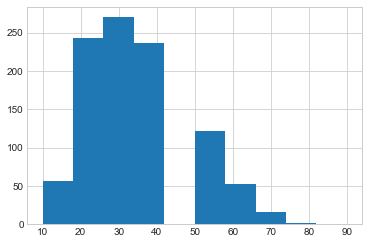

In [77]:
df2['age'].hist();

当数据集中包含异常值时，实现满足$k$-匿名性的最优泛化方法是一个非常有挑战性的任务。*进一步*泛化每一行数据会过分泛化年龄在20-40范围内的数据，损害结果数据的可用性。然而，为了满足$k$-匿名性，显然还需要对年龄进一步泛化，更大地放宽年龄取值的上下界。这是实际使用$k$-匿名性时人们经常需要面对的一种挑战，很难通过自动化的方式解决。实际上，实现满足$k$-匿名性的最优泛化方法已经被证明是一个NP-困难问题。

```{admonition} 挑战
异常值使得实现$k$-匿名性变得非常具有挑战性，即使对于较大的数据集也是如此。实现满足$k$-匿名性的最优泛化方法是一个NP-困难问题。
```

## 移除异常值

异常值问题的一个简单解决方案是将数据集中每个个体的年龄限制在一个特定的范围内，从而完全消除数据集中的异常值。这种方法也会损害数据的可用型，因为这种方法需要用假的年龄值替代真实的年龄值，但这总比泛化每一行数据要好得多。我们可以使用Numpy的`clip`（裁剪）函数来实施这一解决方案。通过`clip`函数，我们将所有年龄取值都限制在60岁及以下，且不再考虑受教育年数这一列数据（方法是通过`clip`函数把所有受教育年数值都替换成一个非常大的值）。

In [81]:
# 裁剪异常值
depths = {
    'age': 1,
    'edu': 1
}
dfp = df.clip(upper=np.array([60, 10000000000000]), axis='columns')
df2 = generalize(dfp.head(500), depths)
isKAnonymized(df2, 7)

True

现在，我们将数据集泛化到满足$k = 7$的$k$-匿名性了！换句话说，我们终于把数据集泛化到了合适的程度。在这一过程中，异常值为满足$k$-匿名性带来了相当多的障碍，甚至使我们很难将数据泛化到满足$k = 2$的$k$-匿名性。

## 总结

- $k$-匿名性是数据集所满足的一种性质，此性质要求每个个体都"融入"到至少包含$k$个人的一个分组中。
- 检查数据集是否满足$k$-匿名性的计算开销是很大的：朴素算法的计算复杂度是$O(n^2)$，更快的算法需要占用相当大的存储空间。
- 可以通过*泛化*使数据集满足$k$-匿名性：泛化是指修改数据集中的数据，将特定的取值替换为更一般的取值，使数据更容易形成分组。
- 实现最优泛化方法是及其困难的，异常值的存在使得泛化变得更具有挑战性。实现满足$k$-匿名性的最优泛化方法是一个NP-困难问题。